In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import networkx as nx
import random
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle as pl
import sys

from pandas import Series, DataFrame
import pandas as pd
# cimport numpy as np


In [3]:
##### Parameters
G_i = 2 # 1 for Friendster, 2 for Les miserables network
if G_i == 1:
    tour_N = 25 #5
    tour_c = 0
    deg_def = [50]
    flag_fn = 1 # 1 for g(v) = d(v) > 25, 4 for avg clustering coeff
if G_i == 2:
    tour_N =  10 #5
    tour_c = 0
    deg_def = [10,4]
    flag_fn = 2 # 1 for g(v) = d(v) > 10, 2 for g(v) = d(v) < 4, 3 for avg degree, 4 for avg clustering coeff
    asy_var_MH_lesmis = [4.4154,14.93508,1.204e+03]
    asy_var_RDS_lesmis = [1.1084,3.3240,272.7649]

max_B = 10000 # maximum budget
no_runs = 100 # no. of runs to average
MH_do = 1 # Flag for doing MH simulation
RDS_do = 1 # Flag for doing RDS simulation
RDSRR_do = 1
MHRR_do = 1

SHOW_VAR_CONVG = 0
ABS_ERROR = 1

In [4]:
def node_fn(node):
    if flag_fn == 1:
        temp = int(G.degree(node)>deg_def[0])
    elif flag_fn == 2:
        temp = int(G.degree(node)<deg_def[1])
    elif flag_fn == 3:
        temp = G.degree(node)
    elif flag_fn == 4:
        deg = G.degree(node)
        if deg < 2:
            temp = 0
        else:
            temp = 2*nx.triangles(G,node)/(deg*(deg-1))
    else:
        print("Not a defined a function")
        sys.exit(0)
    return temp

In [5]:
def MH_sampling(G,B):
    est_MH= []
    est_MH_t = 0
    sample = np.random.choice(G.nodes())
    est_MH_t += node_fn(sample)
    est_MH.append(est_MH_t)
    for ii in range(2,B+1):
        # print "MH_sample: ",ii
        neighbors = list(nx.neighbors(G,sample))
        sample_t = np.random.choice(neighbors)
        if np.random.rand() <= (G.degree(sample)/G.degree(sample_t)):
            sample = sample_t

        est_MH_t += node_fn(sample)
        est_MH.append(est_MH_t/ii)
    return np.array(est_MH)

In [6]:
def RDS_sampling(G,B):
    est_RW = []
    est_RW_t1 = 0
    est_RW_t2 = 0
    sample = np.random.choice(G.nodes())
    deg_pr_sent = G.degree(sample)
    est_RW_t1 += node_fn(sample)/deg_pr_sent
    est_RW_t2 += 1/deg_pr_sent
    est_RW.append(est_RW_t1/est_RW_t2)
    for ii in range(2,B+1):
        # print "rds_sample: ",ii
        neighbors = list(nx.neighbors(G,sample))
        sample = random.choice(neighbors)

        deg_pr_sent = G.degree(sample)
        est_RW_t1 += node_fn(sample)/deg_pr_sent
        est_RW_t2 += 1/deg_pr_sent
        est_RW.append(est_RW_t1/est_RW_t2)
    return np.array(est_RW)

In [7]:
def RDSRR_sampling(G,B):
    M = np.sqrt(B)
    restart_ind = np.square(np.arange(1,M))
    est_RW = []
    est_RW_t1 = 0
    est_RW_t2 = 0
    sample = np.random.choice(G.nodes())
    deg_pr_sent = G.degree(sample)
    est_RW_t1 += node_fn(sample)/deg_pr_sent
    est_RW_t2 += 1/deg_pr_sent
    est_RW.append(est_RW_t1/est_RW_t2)
    for ii in range(2,B+1):
        if ii in restart_ind:
            sample = np.random.choice(G.nodes)
        else:
            neighbors = list(nx.neighbors(G,sample))
            sample = random.choice(neighbors)

        deg_pr_sent = G.degree(sample)
        est_RW_t1 += node_fn(sample)/deg_pr_sent
        est_RW_t2 += 1/deg_pr_sent
        est_RW.append(est_RW_t1/est_RW_t2)
    return np.array(est_RW)

In [8]:
def MHRR_sampling(G,B):
    M = np.sqrt(B)
    restart_ind = np.square(np.arange(1,M))
    est_MH= []
    est_MH_t = 0
    sample = np.random.choice(G.nodes())
    est_MH_t += node_fn(sample)
    est_MH.append(est_MH_t)
    for ii in range(2,B+1):
        if ii in restart_ind:
            sample_t = np.random.choice(G.nodes)
        else:
            neighbors = list(nx.neighbors(G,sample))
            sample_t = np.random.choice(neighbors)
        
        if np.random.rand() <= (G.degree(sample)/G.degree(sample_t)):
            sample = sample_t

        est_MH_t += node_fn(sample)
        est_MH.append(est_MH_t/ii)
    return np.array(est_MH)

In [9]:
if G_i == 1:
    G = nx.read_edgelist("friendster_community1_trimmed.edgelist",nodetype = int)
elif G_i == 2:
    G = nx.les_miserables_graph()
    G = nx.convert_node_labels_to_integers(G, first_label=0, ordering='default', label_attribute=None)
G_no_edges=G.number_of_edges()
G_no_nodes=G.number_of_nodes()

In [10]:
if G_i == 1:
    ##########################CHECK
    if flag_fn == 1:
        F_org = 0.265712074303 #sum([1 for i in G.nodes() if G.degree(i) ])/G_no_nodes
    elif flag_fn == 4:
        F_org = 0.4491010966748313
    else:
        sys.exit("Invalid function")
        
elif G_i == 2:
    if (flag_fn == 1) or (flag_fn == 2):
        F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
    elif flag_fn == 3:
        F_org = 2*G_no_edges/G_no_nodes
    elif flag_fn == 4:
        F_org = nx.average_clustering(G)

In [11]:
if MH_do:
    MSE_MH_t = 0
    for ii in range(1,no_runs+1):
        MSE_MH_t += (MH_sampling(G,max_B)-F_org)**2
    MSE_MH = MSE_MH_t/(no_runs)
    MSE_MH = np.sqrt(MSE_MH)/F_org

In [12]:
if RDS_do:
    MSE_rds_t = 0
    for ii in range(1,no_runs+1):
        MSE_rds_t += (RDS_sampling(G,max_B)-F_org)**2
    MSE_rds = MSE_rds_t/(no_runs)
    MSE_rds = np.sqrt(MSE_rds)/F_org

In [13]:
if RDSRR_do:
    MSE_rdsrr_t = 0
    for ii in range(1,no_runs+1):
        MSE_rdsrr_t += (RDSRR_sampling(G,max_B)-F_org)**2
    MSE_rdsrr = MSE_rdsrr_t/(no_runs)
    MSE_rdsrr = np.sqrt(MSE_rdsrr)/F_org

In [14]:
if MHRR_do:
    MSE_mhrr_t = 0
    for ii in range(1,no_runs+1):
        MSE_mhrr_t += (MHRR_sampling(G,max_B)-F_org)**2
    MSE_mhrr = MSE_mhrr_t/(no_runs)
    MSE_mhrr = np.sqrt(MSE_mhrr)/F_org

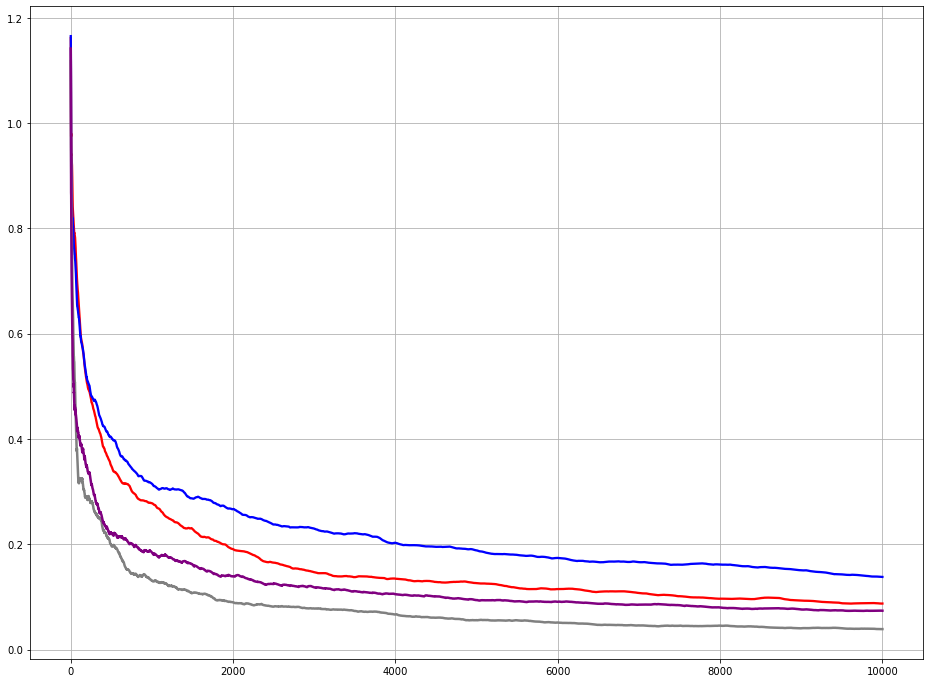

In [15]:
plt.figure(1,figsize=(16,12)) 
plt.plot(np.array(list(range(len(MSE_MH)))),MSE_MH,color='red',linewidth=2.3)
plt.plot(np.array(list(range(len(MSE_mhrr)))),MSE_mhrr,color='blue',linewidth=2.3)
plt.plot(np.array(list(range(len(MSE_rds)))),MSE_rds,color='gray',linewidth=2.5)
plt.plot(np.array(list(range(len(MSE_rdsrr)))),MSE_rdsrr,color='purple',linewidth=2.5)
plt.grid()